<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/13_Neural_Network101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Fully conected Neural Networks
In the introduction we got to know the basic fully-connected neural network architecture.  
We will revisit it later in our session about backpropagation more detail.  
Here, we first look at how to implement such a neural network in `torch` (or PyTorch),  
one of the leading automatic differentiation platforms for machine learning and AI.

Contemporary alternatives are [JAX](https://jax.readthedocs.io/en/latest/) and [TensorFlow](https://www.tensorflow.org/),  
which are backed by google and both have their advantages and disadvantages. All libraries are able to perform the tasks  
we are looking at, and it is solely a matter of preference which one we choose.

In [1]:
import torch
from torch import nn

/home/qottmann/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To build a neural network in (py)torch, you are expected to fill a "template" class  
that has a `__init__` and `forward` method. This varies for different machine learning  
frameworks, but the overall logic is the same.

In [53]:
in_dim = 28*28
out_dim = 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.neural_network = nn.Sequential(
            nn.Linear(in_dim, 512),  # input dimension, hidden1 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, 512),     # hidden1 dimension, hidden2 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, out_dim), # hidden2 dimension, output dimension
            #nn.Softmax(dim=1)        # special output activation function
        )

    def forward(self, x):
        x = self.flatten(x)          # input data preparation
        output = self.neural_network(x)
        return output

In [54]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (neural_network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For parallelization, PyTorch (and other ML frameworks) are built to process data in batches.  
Therefore, the input is always assumed to have the first dimension to be the `batch_size`.  
If we want to process a single input, we need to accont for a dummy dimension `batch_size=1`.  

In [55]:
try:
    X = torch.rand(in_dim)
    output = model(X) # results in an error
except:
    X = torch.rand(1, in_dim)
    output = model(X)

In [56]:
output.shape

torch.Size([1, 10])

E1: Due to the `flatten` function in the forward pass, the input is rather flexible, try inputting alternatively shaped tensors. What is the constraint that needs to be fulfilled?    
Here is one example:

In [57]:
X = torch.rand(1, 2, 14, 28)
model(X)

tensor([[ 0.0053, -0.0237,  0.0093, -0.0687,  0.0061,  0.0333, -0.0068, -0.0198,
          0.0557,  0.0745]], grad_fn=<AddmmBackward0>)

E2: We want the output of our NN to be the probability distribution for `out_dim = 7` different categories.  
Modify the network such that the output resembles a proper probability distribution, i.e. that 
$$\sum_{i=1}^\text{out_dim} p_i = 1$$ 
and $1\geq p_i \geq 0$

In [58]:
torch.isclose(torch.sum(model(X)), torch.tensor(1.))

tensor(False)

In [59]:
torch.all(model(X)>0)

tensor(False)

(Note that you can use most of the standard `numpy` functions in torch)  
Hint: Look up the so-called softmax function $\text{Softmax}: \mathbb{R}^m \mapsto \mathbb{R}^m$
$$
\left(\text{Softmax}(x)\right)_i = \frac{e^{x_i}}{\sum_{j=1}^m e^{x_j}}
$$
for $x \in \mathbb{R}^m$

# Part II: Backpropagation
We understand the _forward pass_ of a neural network, now it is time to learn how to optimize it. Curiosly, this is done in a similar fashion but in the reverse direction through a _backward pass_ via an algorithm called backpropagation. One of the big benefits of modern machine learning libraries like `torch` is they automatically perform this task for us. Still, we should know what is going on under the hood for a deeper understanding.


For this, we introduce the vector form of the forward pass in terms of the activation
$$a^\ell = f(z^\ell)$$
with weighted inputs
$$z^\ell = w^\ell a^{\ell-1} + b^\ell.$$
Note that all quantities are vectors, except for $w^\ell$, which is a matrix.  
The function $f$ may be different for each layer, though for simplicity we do not specify this explicitly.  
The over output of the network is given by
$$a^L = f(z^L) = f(w^L f(z^{L-1}) + b^L) =..,$$
a nested function of multiple activations and matrix multiplications.

One of many possible choices for a loss function is the $\ell^2$ norm
$$C = \frac{1}{2n} \sum_x ||y(x) - a^L(x)||^2.$$
Here, $a^L$ is the activation of the last layer, i.e. the NN output, and $y(x)$ is the label of the example $x$.  
For example, for binary classification (2 classes), $y(x)=(1,0)$ or $y(x)=(0,1)$, depending which class the example belongs to.

Our goal is it to minimize this loss function to achieve faithful predictions. This is done via so-called gradient descent.  
The idea is to change the trainable parameters of the neural network, $w$ and $b$, in the direction of steepest descent, which is exactly the gradient.  
We update the parameters according to
$$b^\ell \mapsto b^\ell - \alpha \nabla_{b^\ell} C$$
$$w^\ell \mapsto b^\ell - \alpha \nabla_{w^\ell} C$$
where $\alpha$ is a so-called hyper parameter, the learning rate, set by the user. This update rule is repeated many times until a minimum is reached.  
In practice we use more involved optimization routines that take  
the trajectory of past updates

We follow the derivation of the gradient of $C$ based on [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html) and find the equations for backpropagation:

$$\delta^L = \nabla_aC \odot f'(z^L)$$
$$\delta^\ell = \left((w^{\ell + 1})^T \delta^{\ell+1} \right) \odot f'(z^\ell)$$
$$\frac{\partial C}{\partial b^\ell_j} = \delta^\ell_j $$
$$\frac{\partial C}{\partial w^\ell_{jk}} = a^{\ell-1}_k \delta^\ell_j$$

Where in the case of the $\ell^2$ norm above, $\nabla_a C = \frac{1}{n} \sum_x \sum_i (y_i(x) - a_i(x))$.

Ex: For a forward pass with $x=(1,0)$,
$w^1 = \begin{pmatrix}
1 & 2 \\
1 & 2 \\
1 & 2 
\end{pmatrix}$, $w^2 = \begin{pmatrix}
-1 & -1 & -1\\
2 & 2 & 2
\end{pmatrix}$, $y=(1,0)$, and $f(x)=|x|$ (element-wise), compute $\frac{\partial}{\partial w^1_{1,1}} C$ and $\frac{\partial}{\partial w^1_{1,2}} C$

In [60]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [61]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [batch_size, color_channel, height, width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [batch_size, color_channel, height, width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [62]:
from matplotlib import pyplot as plt
import numpy as np

# technically you should not do the following because it defeats the purpose of having the data loader in the first place
test_data = list(test_dataloader)

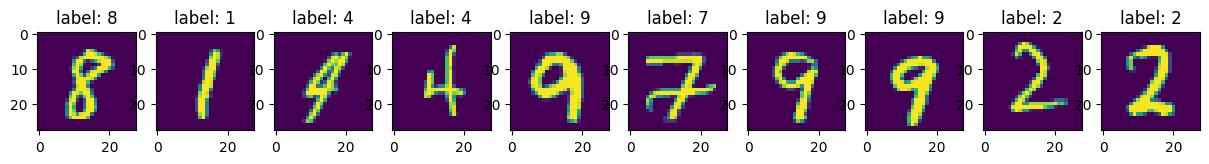

In [63]:
fig, axs = plt.subplots(ncols=10, figsize=(15, 4))
for i, pick in enumerate(np.random.randint(len(test_data),size=10)):
    ax = axs[i]
    ax.imshow(test_data[pick][0][0][0, :, :])
    ax.set_title(f"label: {test_data[pick][1][0]}")

In [75]:
loss_fn = nn.CrossEntropyLoss() # nn.MSELoss() # mean squared error (MSE) loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # stochastic gradient descent (SGD) optimizer

In [76]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute accuracy
    train_acc = correct/size * 100
    return loss, train_acc

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_acc = 100*correct
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, test_acc



In [77]:
epochs = 20
train_losss, train_accs = [], []
test_losss, test_accs = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    train_losss.append(train_loss)
    train_accs.append(train_acc)
    test_losss.append(test_loss)
    test_accs.append(test_acc)
print("Done!")

Epoch 1
Test Error: Accuracy: 78.0%, Avg loss: 1.253924
Epoch 2


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.plot(train_losss, label="train")
ax.plot(test_losss, "x-", label="test")

ax.set_title("loss")
ax.set_xlabel("epoch")
ax.legend()

ax = axs[1]
ax.plot(train_accs, label="train")
ax.plot(test_accs, "x-", label="test")

ax.set_title("accuracy")
ax.set_xlabel("epoch")
ax.legend()

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [74]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297947  [    0/60000]
loss: 2.299465  [ 6400/60000]
loss: 2.292983  [12800/60000]
loss: 2.284586  [19200/60000]
loss: 2.278223  [25600/60000]
loss: 2.280162  [32000/60000]
loss: 2.269141  [38400/60000]
loss: 2.281395  [44800/60000]
loss: 2.260871  [51200/60000]
loss: 2.252883  [57600/60000]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.253733 

Epoch 2
-------------------------------
loss: 2.250625  [    0/60000]
loss: 2.248637  [ 6400/60000]
loss: 2.250579  [12800/60000]
loss: 2.222542  [19200/60000]
loss: 2.227488  [25600/60000]
loss: 2.230035  [32000/60000]
loss: 2.206382  [38400/60000]
loss: 2.232095  [44800/60000]
loss: 2.197662  [51200/60000]
loss: 2.182797  [57600/60000]
Test Error: 
 Accuracy: 56.4%, Avg loss: 2.185726 

Epoch 3
-------------------------------
loss: 2.181756  [    0/60000]
loss: 2.173243  [ 6400/60000]
loss: 2.185223  [12800/60000]
loss: 2.129055  [19200/60000]
loss: 2.144519  [25600/60000]
loss: 2.147302  [32000/600